# Random forest predictions

In [722]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from scipy import stats

import matplotlib.pylab as plt
plt.style.use('ggplot')

def root_mean_squared_log_error(y_true, y_pred):
    # Alternatively: sklearn.metrics.mean_squared_log_error(y_true, y_pred) ** 0.5
    assert (y_true >= 0).all() 
    assert (y_pred >= 0).all()
    log_error = np.log1p(y_pred) - np.log1p(y_true)  # Note: log1p(x) = log(1 + x)
    return np.mean(log_error ** 2) ** 0.5

In [723]:
metaData_apartment = pd.read_json('../data/apartments_meta.json')
metaData_building = pd.read_json('../data/buildings_meta.json')
metaData_apartment.at[0, 'name'] = 'apartment_id'
metaData_building.at[0, 'name'] = 'building_id'
metaData = pd.concat([metaData_apartment, metaData_building])

train_apartment = pd.read_csv('../data/apartments_train.csv')
train_building = pd.read_csv('../data/buildings_train.csv')
train = pd.merge(train_apartment, train_building.set_index('id'), how='left', left_on='building_id', right_on='id')
# train.rename(columns={'id_x' : 'apartment_id'}, inplace=True)
# train.drop('id_y', axis=1, inplace=True)
train = train.fillna(train.mean())

test_apartment = pd.read_csv('../data/apartments_test.csv')
test_building = pd.read_csv('../data/buildings_test.csv')
test = pd.merge(test_apartment, test_building.set_index('id'), how='left', left_on='building_id', right_on='id')
# test.rename(columns={'id_x' : 'apartment_id'}, inplace=True)
# test.drop('id_y', axis=1, inplace=True)
test = test.fillna(test.mean())

In [736]:
####### SETTINGS ##############
test_size = 0.2
random_state_split = 42
outliers_value = 4
all_features = ['seller','area_total','area_kitchen','area_living','floor','rooms','layout','ceiling','bathrooms_shared','bathrooms_private','windows_court','windows_street','balconies','loggias','condition','phones','building_id', 'new','latitude','longitude','district','constructed','material','stories','elevator_without','elevator_passenger','elevator_service','parking','garbage_chute','heating']
features = ['area_total','ceiling', 'rooms','bathrooms_shared','latitude','longitude','district','constructed','stories','parking'] #['area_total', 'area_living', 'ceiling', 'constructed', 'stories', 'bathrooms_shared', 'latitude', 'longitude', 'parking', 'district']
n_estimators=200
criterion='mse'
max_depth=15
min_weight_fraction_leaf=0.0
max_features='sqrt'
max_leaf_nodes=None
min_impurity_decrease=0.0
bootstrap=True
oob_score=False
n_jobs=None
random_state_model=2
verbose=0
warm_start=True
ccp_alpha=0.0
max_samples=None



In [737]:

train_data, test_data = train_test_split(train, test_size=test_size, random_state=random_state_split, stratify=np.log(train.price).round())
train_data = train_data[(np.abs(stats.zscore(train_data['price'])) < outliers_value)]
X_train, y_train = train_data[features], train_data['price']
X_test, y_test = test_data[features], test_data['price']
# X_train_norm = (X_train - X_train.mean())/X_train.std()
# y_train_norm = (y_train - y_train.mean())/y_train.std()

In [738]:
######### BASE
y_train = train_data.price
y_valid = test_data.price

mean = y_train.mean()
y_train_hat = np.full(len(y_train), mean)
y_valid_hat = np.full(len(y_valid), mean)

print(f'Train rmsle: {root_mean_squared_log_error(y_true=y_train, y_pred=y_train_hat) :.4f}')
print(f'Valid rmsle: {root_mean_squared_log_error(y_true=y_valid, y_pred=y_valid_hat) :.4f}')

Train rmsle: 0.9300
Valid rmsle: 0.9624


In [739]:
model2 = RandomForestRegressor(
    n_estimators=n_estimators,
    criterion=criterion,
    max_depth=max_depth,
#     min_samples_split=2,
#     min_samples_leaf=2,
    min_weight_fraction_leaf=min_weight_fraction_leaf,
    max_features=max_features,
    max_leaf_nodes=max_leaf_nodes,
    min_impurity_decrease=min_impurity_decrease,
    bootstrap=bootstrap,
    oob_score=oob_score,
    n_jobs=n_jobs,
    random_state=random_state_model,
    verbose=verbose,
    warm_start=warm_start,
    ccp_alpha=ccp_alpha,
    max_samples=max_samples
)

In [740]:
model2.fit(X_train, y_train)

RandomForestRegressor(max_depth=15, max_features='sqrt', n_estimators=200,
                      random_state=2, warm_start=True)

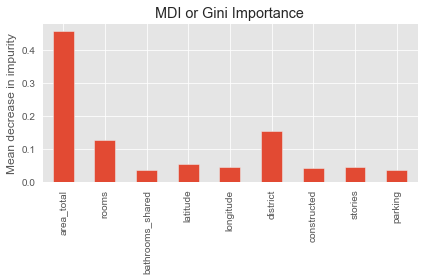

In [743]:
importances = model2.feature_importances_
forest_importances = pd.Series(importances, index=X_train.columns)

fig, ax = plt.subplots()
forest_importances.plot.bar(ax=ax)
ax.set_title("MDI or Gini Importance")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [744]:
# Unormalize data


In [745]:
rf_prediction = model2.predict(X_test)

In [746]:
rf_mse = root_mean_squared_log_error(rf_prediction, y_test)
print('Test MSE:', rf_mse)

Test MSE: 0.184851062339462


Text(0, 0.5, 'Ground Truth')

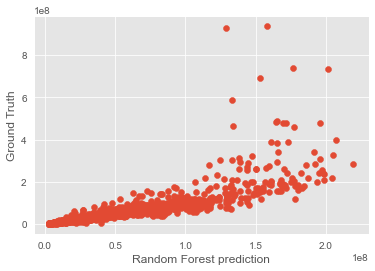

In [747]:
plt.scatter(rf_prediction, y_test)
plt.xlabel('Random Forest prediction')
plt.ylabel('Ground Truth')

In [751]:
# ########## Create submission
# # Fit model to the full dataset 
# train = train[(np.abs(stats.zscore(train['price'])) < outliers_value)]
# X_train = train[features]
# y_train = train['price']
# print(f'Num nans in train {X_train.isna().any(axis=1).sum()}')
# model = RandomForestRegressor(max_depth=20).fit(X_train, y_train)

# # Generate predictions for test set 
# X_test = test[features]
# X_test_nan = X_test.isna().any(axis=1)
# print(f'Num nans in test: {X_test_nan.sum()}')
# y_test_hat = model.predict(X_test[~X_test_nan])

# # Construct submission dataframe
# submission = pd.DataFrame()
# submission['id'] = test.id
# submission.loc[~X_test_nan, 'price_prediction'] = y_test_hat # Predict on non-nan entries
# submission['price_prediction'].fillna(y_train.mean(), inplace=True) # Fill missing entries with mean predictor
# print(f'Generated {len(submission)} predictions')

# # Export submission to csv with headers

# ############################################ CHANGE NAME !!!!!!!!!!
# submission.to_csv('sample_RF_3.csv', index=False)
# settings = {
#     'train_MSE': root_mean_squared_log_error(rf_prediction, y_test),
#     'features':features, 
#     'outliers_value':outliers_value,
#     'nan_delete':'mean',
#     'test_size' : test_size,
#     'random_state_split' :  random_state_split,
#     'n_estimators': n_estimators,
#     'criterion': criterion,
#     'max_depth': max_depth,
#     'min_weight_fraction_leaf': min_weight_fraction_leaf,
#     'max_features': max_features,
#     'max_leaf_nodes': max_leaf_nodes,
#     'min_impurity_decrease': min_impurity_decrease,
#     'bootstrap': bootstrap,
#     'oob_score': oob_score,
#     'n_jobs': n_jobs,
#     'random_state': random_state_model,
#     'verbose': verbose,
#     'warm_start': warm_start,
#     'ccp_alpha': ccp_alpha,
#     'max_samples': max_samples,
#     'other':'None',
#     }
# with open('sample_RF_3_settings.json', 'w') as fp:
#     json.dump(settings, fp)

Num nans in train 0
Num nans in test: 0
Generated 9937 predictions
